# Embedding workflow using DINOv2

This notebook focuses on the **Feature Extraction** pipeline. 

We utilize the fine-tuned model **ViTD2PC24All** ([DINOv2](https://dinov2.metademolab.com/)) to extract high-dimensional embeddings from the single-label train images and multi-label test images.

We'll **visualize**, **tile**, and **process** these embeddings to support patch-wise multi-label inference using PyTorch and Faiss.

![diagram](../images/pytorch-webinar-diagram.png)

In [1]:
%load_ext autoreload
%autoreload 2

## Now to load the parquet file from disk and visualize the images

In [2]:
import pandas as pd
from rich import print as pprint

pd.options.display.precision = 2
pd.options.display.max_rows = 10
pd.options.display.max_columns = 25

# root_dir = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025"
# dataset_dir = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2025_test_images/PlantCLEF2025_test_images"
# hf_dataset_dir = "/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test/HF_dataset"
dir(pd.options.display)

['chop_threshold',
 'colheader_justify',
 'date_dayfirst',
 'date_yearfirst',
 'encoding',
 'expand_frame_repr',
 'float_format',
 'html',
 'large_repr',
 'max_categories',
 'max_columns',
 'max_colwidth',
 'max_dir_items',
 'max_info_columns',
 'max_info_rows',
 'max_rows',
 'max_seq_items',
 'memory_usage',
 'min_rows',
 'multi_sparse',
 'notebook_repr_html',
 'pprint_nest_depth',
 'precision',
 'show_dimensions',
 'unicode',
 'width']

In [7]:
from plantclef.datasets.preprocessing.hf.train_val_test_subsets_to_hf import (
    # Config,
    preprocess_hf_dataset,
    HFDataset,
)
from plantclef.utils.imutils import ImageProcessor
from plantclef.datasets.preprocessing.hf.parallel_utils import (
    # ImageProcessor,
    ResizeDatasetConfig,
)
import os

from tqdm import tqdm
from datasets import Image
from functools import partial

# cfg = Config()
cfg = ResizeDatasetConfig()
cfg.data_cfg.show()

{'shortest_edge': 588}
Config(
    name='train_val_test',
    x_col='image_path',
    label_col='species_id',
    target_col='label_idx',
    image_size={'shortest_edge': 588},
    interpolation_mode='BILINEAR',
    dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2
025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800',
    metadata_cache_path='/teamspace/studios/this_studio/plantclef-vision/data/pl
antclef2025/competition-metadata/PlantCLEF2024_single_plant_training_metadata.pa
rquet',
    hf_datasets_root_dir='/teamspace/studios/this_studio/plantclef-vision/data/h
f',
    hf_dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/hf/plan
tclef2025/single_label_train_val_test',
    _hf_dataset_path='/teamspace/studios/this_studio/plantclef-vision/data/hf/pl
antclef2025/single_label_train_val_test/shortest_edge_588/None'
)


In [8]:
cfg.data_cfg.set_subset(None)

In [10]:
cfg.data_cfg.subset is None

True

In [9]:
cfg.data_cfg.show()

Config(
    name='train_val_test',
    x_col='image_path',
    label_col='species_id',
    target_col='label_idx',
    image_size={'shortest_edge': 588},
    interpolation_mode='BILINEAR',
    dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2
025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800',
    metadata_cache_path='/teamspace/studios/this_studio/plantclef-vision/data/pl
antclef2025/competition-metadata/PlantCLEF2024_single_plant_training_metadata.pa
rquet',
    hf_datasets_root_dir='/teamspace/studios/this_studio/plantclef-vision/data/h
f',
    hf_dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/hf/plan
tclef2025/single_label_train_val_test',
    _hf_dataset_path='/teamspace/studios/this_studio/plantclef-vision/data/hf/pl
antclef2025/single_label_train_val_test/shortest_edge_588/None'
)


In [4]:
cfg.data_cfg.show()

AttributeError: 'Config' object has no attribute 'data_cfg'

In [ ]:
num_batches_per_shard = 4
batch_size = 16  # 256
shard_size = batch_size * 4
resume_from_shard = cfg.get_last_existing_shard_idx()  # Gets the index of the last shard written to cfg.hf_dataset_path, else returns 0 to start from beginning

shard_idx = resume_from_shard or 0


dataset_subsets = preprocess_hf_dataset(cfg)
ds = dataset_subsets["train"]

shards = ds.batch(shard_size).skip(shard_idx)

total_size = len(ds)
num_proc = os.cpu_count()
num_shards = total_size // shard_size + 1

process_batch = ImageProcessor(
    image_size={"shortest_edge": 588}, interpolation_mode="BILINEAR"
).process_batch_with_key

process_func = partial(process_batch, key="image_path")

for shard in tqdm(shards):
    shard = HFDataset.from_dict(shard)

    processed_shard = shard.map(
        process_func,
        input_columns=cfg.x_col,
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        desc=f"Processing shard {shard_idx} of {num_shards}",
    )

    processed_shard = processed_shard.rename_column(cfg.x_col, "image")
    processed_shard = processed_shard.cast_column("image", Image())

    shard_path = cfg.get_shard_path(shard_idx, shard_size, total_size)

    processed_shard.save_to_disk(shard_path)

    shard_idx += 1
    break

In [2]:
256 * 5113 / (500 * 32)

81.808

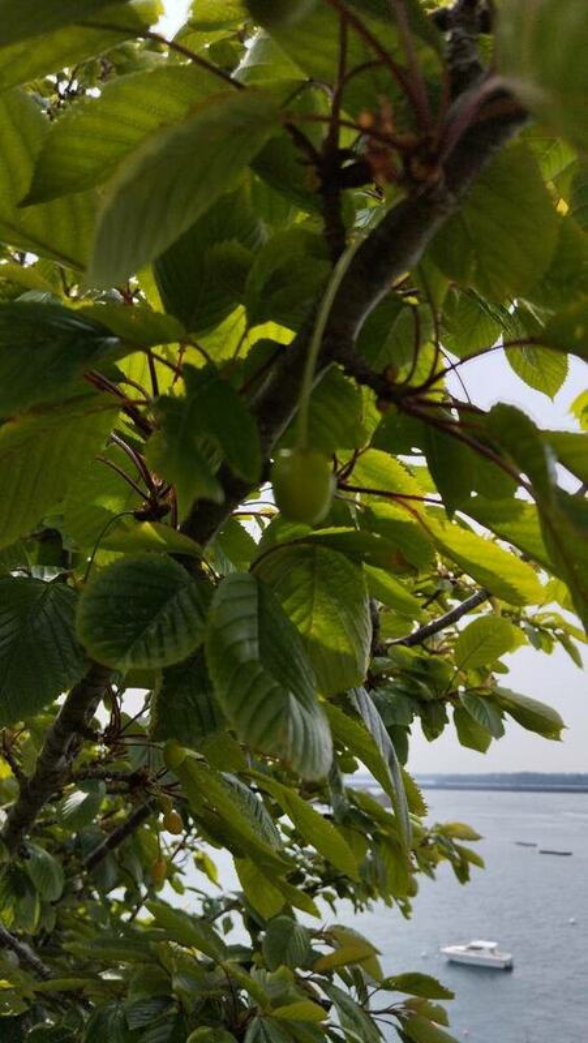

In [35]:
processed_shard[45]["image_path"]

In [18]:
image_path = shard[0]["image_path"]


img_processor = ImageProcessor(
    image_size={"shortest_edge": 588}, interpolation_mode="BILINEAR"
)

img = img_processor.read_image(image_path)
resized_img = img_processor.resize_image(img)

In [21]:
img.size

(600, 800)

In [20]:
resized_img.size

(588, 784)

In [122]:
import os


# def measure_image(image_path):
#     with PIL.Image.open(image_path) as img:
#         width, height = img.size
#     return {"width": width, "height": height}

(600, 800)

In [60]:
# from tqdm import tqdm
# batches_ds_list = [HFDataset.from_dict(b) for b in tqdm(batches.take(10))]
# batches_ds = concatenate_datasets(batches_ds_list)
# from datasets import Dataset as HFDataset, Image
# import os

# batch = HFDataset.from_dict(batches[0])
# batch


# tx = get_dict_transform(
#     transform_kwargs={"image_size": {"shortest_edge": 716}}, input_columns=cfg.x_col
# )

# # print(f"[INITIATING dataset.map(resize)] -- using num_proc={os.cpu_count()}")
# batch = batch.cast_column(cfg.x_col, Image())
# batch = batch.map(tx, input_columns=cfg.x_col, num_proc=os.cpu_count())

{'examples_iterable': {'shard_idx': 0,
  'shard_example_idx': 0,
  'type': 'ArrowExamplesIterable'},
 'epoch': 0}

In [29]:
# val_ds.features

{'image_path': Value(dtype='string', id=None),
 'label_idx': Value(dtype='int64', id=None),
 'image_name': Value(dtype='string', id=None),
 'organ': Value(dtype='string', id=None),
 'species_id': Value(dtype='int64', id=None),
 'obs_id': Value(dtype='int64', id=None),
 'author': Value(dtype='string', id=None),
 'altitude': Value(dtype='float64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'species': Value(dtype='string', id=None),
 'genus': Value(dtype='string', id=None),
 'family': Value(dtype='string', id=None),
 'learn_tag': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [31]:
# val_ds.take(10)["__index_level_0__"]
# ds = HFDataset.from_dict({"image": image_paths, "file_path": image_paths})
# ds = ds.cast_column("image", Image())
# ds = ds.cast_column("file_path", Value("string"))
# metadata.info(verbose=True)
# metadata[keep_cols].info(verbose=True)
# metadata["gbif_species_id"].nunique()
# metadata["species_id"].nunique()

# metadata["gbif_species_id"].isna().sum()
# metadata["species_id"].isna().sum()
# metadata.head(3)
# metadata.describe(include="all")`

[479, 489, 490, 491, 492, 493, 495, 496, 497, 498]

## Running torch_pipeline with HFPlantDataset

In [6]:
from plantclef.embed.workflow import Config
from plantclef.embed.utils import print_dir_size
import os

cfg = Config()
pprint(cfg)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(


Config(
    use_grid=True,
    grid_size=3,
    image_size=546,
    batch_size=16,
    cpu_count=4,
    top_k=5,
    device='cpu',
    root_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025',
    dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2
025_test_images/PlantCLEF2025_test_images',
    hf_dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test/HF_dataset
',
    embeddings_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings',
    test_embeddings_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test',
    folder_name='test_grid_3x3_embeddings',
    test_embeddings_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/t
est_grid_3x3_embeddings',
    test_submission_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/t
est_grid_3x3_embeddings-submission.csv',
    config_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_
3x3_embeddings-config.json'
)

In [14]:
import csv
import pandas as pd


df = pd.read_csv(cfg.test_submission_path)

df = df.assign(quadrat_id=df["quadrat_id"].apply(lambda x: os.path.splitext(x)[0]))

df.to_csv(cfg.test_submission_path, sep=",", index=False, quoting=csv.QUOTE_ALL)
df

,quadrat_id,species_ids
0,2024-CEV3-20240602,"[1654010, 1395063, 1392662, 1414387, 1743646]"
1,CBN-PdlC-A1-20130807,"[1744569, 1361917, 1356350, 1418612, 1361129]"
2,CBN-PdlC-A1-20130903,"[1744569, 1392608, 1361382, 1361068, 1361971]"
3,CBN-PdlC-A1-20140721,"[1529289, 1374758, 1402995, 1741880, 1362066]"
4,CBN-PdlC-A1-20140811,"[1361281, 1418612, 1356350, 1392608, 1722440]"
...,...,...
2100,RNNB-8-5-20240118,"[1361437, 1655199, 1357049, 1722441, 1414356]"
2101,RNNB-8-6-20240118,"[1655199, 1363434, 1359297, 1357962, 1361703]"
2102,RNNB-8-7-20240118,"[1359297, 1356521, 1363553, 1357358, 1362711]"
2103,RNNB-8-8-20240118,"[1359650, 1396330, 1743962, 1357962, 1388788]"


In [5]:
print_dir_size(cfg.test_embeddings_path)

Analyzing disk usage of directory: /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_3x3_embeddings
Directory Disk Usage: 543M	/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_3x3_embeddings
2025-05-08 08:42:53


In [22]:
# top_1 = []
# top_2 = []
# top_3 = []
# top_4 = []
# top_5 = []

# for i, row in df.iterrows():
#     top_1.append(row["logits"][0])
#     top_2.append(row["logits"][1])
#     top_3.append(row["logits"][2])
#     top_4.append(row["logits"][3])
#     top_5.append(row["logits"][4])

#     print(i)
#     # pprint(row)

#     if i >= 5:
#         break

# print(f"top_1: {top_1}")
# print(f"top_2: {top_2}")
# print(f"top_3: {top_3}")
# print(f"top_4: {top_4}")
# print(f"top_5: {top_5}")
# top_species_ids = [s_id for s_id, _ in [*top_1, *top_2, *top_3, *top_4, *top_5]]

/tmp/ipykernel_33614/1293469598.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.apply(select_top_k_unique_logits, top_k=top_k).rename("logits").reset_index()


,image_name,logits
0,2024-CEV3-20240602.jpg,"[(1654010, 0.44266772270202637), (1395063, 0.3..."
1,CBN-PdlC-A1-20130807.jpg,"[(1744569, 0.2301855832338333), (1361917, 0.22..."
2,CBN-PdlC-A1-20130903.jpg,"[(1744569, 0.16917195916175842), (1392608, 0.1..."
3,CBN-PdlC-A1-20140721.jpg,"[(1529289, 0.14910352230072021), (1374758, 0.1..."
4,CBN-PdlC-A1-20140811.jpg,"[(1361281, 0.12936192750930786), (1418612, 0.1..."
...,...,...
2100,RNNB-8-5-20240118.jpg,"[(1361437, 0.7179210782051086), (1655199, 0.52..."
2101,RNNB-8-6-20240118.jpg,"[(1655199, 0.37736761569976807), (1363434, 0.2..."
2102,RNNB-8-7-20240118.jpg,"[(1359297, 0.30361855030059814), (1356521, 0.2..."
2103,RNNB-8-8-20240118.jpg,"[(1359650, 0.3005388379096985), (1396330, 0.28..."


## Explore embeddings

### Get embeddings and logits from model.predict_step

### Get image names from HFDataset -> Create a pandas DataFrame to match image names to logits + embeddings

# Misc below

### Extracting embeddings from single-label training images

We extract embeddings from a small subset of training images to validate our pipeline.  
We don't perform tiling on the train images (we use the full image) and extract 768-dimensional ViT embeddings.

### Embedding test images with tiling (3x3)


Since the test images are high-resolution and contain multiple plant species, we split them into a 3x3 grid of tiles.
- We **extract embeddings** and **top-*K* logits** from each tile using the ViT model.  
- This **patch-wise representation** is critical for enabling multi-label classification.

### Analyzing classifier logits per tile

For each tile, we look at the **top predicted species** and associated confidence scores (`logits`).  
This helps interpret how confident the model is in identifying species in each patch.

### Embedding the entire test set with tiling

We scale up our embedding pipeline to process the full test dataset using **3x3 tiling**.  
This prepares the data for the downstream tasks of efficient **nearest neighbor search** and **multi-label prediction** at the tile level.

### Saving test embeddings and logits to Parquet

We serialize the full test embeddings into partitioned Parquet files for later use in inference pipelines.  
The logits are stored as JSON strings for flexibility.

## Embedding the full training set (no tiling)

We repeat the embedding process on the **full training dataset**, this time *without tiling*.  
This enables us to use the embeddings directly or as a **transfer learning** approach in a Faiss-based nearest neighbor retrieval system.

### Saving the training embeddings to Parquet

Finally, we save the full training embeddings in partitioned Parquet format to support fast, distributed retrieval during inference.

### Embeddings Ready for Downstream Use

We now have rich ViT embeddings for both train and test datasets, ready for use in:
- Multi-label classification
- Retrieval-based inference
- Nearest Neighbor Search